In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
import shap
from sklearn.model_selection import train_test_split
from utils.load_config_file import load_config_file

In [40]:
# ## Load Pre-Conversion MA data with Post-Conversion LTV Values
# ma_data = pd.read_csv("data/with_zcta/ma_ltv_data.csv", low_memory=False)
# ma_data.head()

In [41]:
# ma_data.shape

### SYNTHETIC DATA TESTS

In [2]:
# synth_data = pd.read_csv("s3://hc-data-science/med-adv-sales-data/synthetic_data_1M_rows.csv", low_memory= False)
# synth_data



(1000000, 153)

In [4]:
# synth_data.LTV

0          773.000000
1          325.000000
2         1052.000000
3          249.333333
4          450.916667
             ...     
999995     780.000000
999996     436.333333
999997     897.000000
999998     498.666667
999999     193.250000
Name: LTV, Length: 1000000, dtype: float64

In [4]:
# data = synth_data.copy()
# data.shape

(1000000, 152)

In [5]:
def fix_carrier_names(name):
    carrier_names_repl = {
        "O65 - United Health Care": ["O65 - AARP UnitedHealthcare Insurance Company"],
        "O65 - Anthem": [
            "O65 - Anthem Blue Cross",
            "O65 - Anthem Blue Cross and Blue Shield",
            "O65 - Anthem Blue Cross Life and Health Insurance Company",
            "O65 - Anthem and Blue Shield",
            "O65 - Anthem Life and Health Insurance Company"
        ],
        "O65 - Wellcare": ["O65 - WellCare"]
    }
    for k in carrier_names_repl:
        if name in carrier_names_repl[k]:
            carrier = k
            break
        else:
            carrier = name
    
    return carrier

data["carrier_hc"] = data["carrier_hc"].apply(lambda x: fix_carrier_names(x))

In [6]:
data.carrier_hc.unique()

array(['O65 - United Health Care', 'O65 - Centene Corporation',
       'O65 - Humana', 'O65 - Empire BlueCross BlueShield', 'O65 - Aetna',
       'O65 - Anthem', 'O65 - AmeriGroup', 'O65 - Wellcare',
       'O65 - Cigna', 'O65 - Blue Shield of California',
       'O65 - BlueCross BlueShield of Texas', 'O65 - Blue Cross of Idaho'],
      dtype=object)

In [7]:
def cal_ltv(dur, carrier):
    comms = pd.read_csv("data/carrier_commission_simplified.csv")
    # print(carrier)
    comms = comms[comms["carrier"] == carrier]
    # print(comms)
    if not np.isnan(dur) and not comms.empty:
        if dur <= 12:
            ltv = dur * (comms["year1_commission_new"].item() / 12)
        elif dur > 12:
            ltv = comms["year1_commission_new"].item() + ((dur - 12) * (comms["year2_commission"].item() / 12))  
        else:
            ltv = np.nan
    else:
        ltv = np.nan
    return ltv

data["LTV"] = data.apply(lambda x: cal_ltv(
    x['duration_in_months'],
    x['carrier_hc']
), axis=1)


In [8]:
data.to_csv("data/cms_ma_synth/cms_ma_ltv.csv", index=False)

In [9]:
data.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'contract_hc',
       'carrier_hc', 'type_hc', 'plan_hc',
       ...
       'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms', 'LTV'],
      dtype='object', length=153)

### Load synthetic data locally

In [2]:
## Load synthetic data locally
synth_data = pd.read_csv("data/cms_ma_synth/cms_ma_ltv.csv", low_memory= False)
synth_data.shape

(1000000, 153)

In [4]:
synth_temp = synth_data[:5]
synth_temp

,zcta,county,state,fips,age,gender,contract_hc,carrier_hc,type_hc,plan_hc,...,ms_adult bmi assessment,ms_care for older adults – functional status assessment,ms_appeals auto–forward,ms_appeals upheld,ms_plan all-cause readmissions,ms_controlling blood pressure,ms_beneficiary access and performance problems,ms_high risk medication,star_rating_cms,LTV
0,31405,Chatham,GA,13051,65.0,M,H6528,O65 - United Health Care,MAPD,AARP Medicare Advantage Choice (PPO),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,773.000000
1,85716,Pima,AZ,4019,84.0,F,H0351,O65 - Centene Corporation,MAPD,Allwell CHF/Diabetes Medicare (HMO C-SNP),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,325.000000
2,60062,Cook,IL,17031,66.0,F,H2001,O65 - United Health Care,MAPD,AARP Medicare Advantage Choice Plan 1 (PPO),...,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,1052.000000
3,24563,Pittsylvania,VA,51143,73.0,M,H8145,O65 - Humana,MA,Humana Gold Choice H8145-120 (PFFS),...,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,249.333333
4,75477,Lamar,TX,48277,82.0,F,H2001,O65 - United Health Care,MAPD,AARP Medicare Advantage Choice Plan 1 (PPO),...,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,450.916667


In [17]:
synth_temp[synth_temp.columns[5]]

0    M
1    F
2    F
3    M
4    F
Name: gender, dtype: object

In [3]:
list(synth_data.columns)

['zcta',
 'county',
 'state',
 'fips',
 'age',
 'gender',
 'contract_hc',
 'carrier_hc',
 'type_hc',
 'plan_hc',
 'enrollment_year',
 'enrollment_month',
 'duration_in_months',
 'star_rating_hc',
 'zcta_land_area_m2',
 'county_land_area_m2',
 'intersection_land_area_m2',
 'intersection_pct_county_land_area',
 'intersection_pct_zcta_land_area',
 'latitude',
 'longitude',
 'usc_land_area_m2',
 'cdc_all_teeth_lost',
 'cdc_annual_checkup',
 'cdc_arthritis',
 'cdc_binge_drinking',
 'cdc_copd',
 'cdc_cancer_except_skin',
 'cdc_cervical_cancer_screening',
 'cdc_cholesterol_screening',
 'cdc_chronic_kidney_disease',
 'cdc_colorectal_cancer_screening',
 'cdc_core_preventive_services_for_older_men',
 'cdc_core_preventive_services_for_older_women',
 'cdc_coronary_heart_disease',
 'cdc_current_asthma',
 'cdc_current_smoking',
 'cdc_dental_visit',
 'cdc_depression',
 'cdc_diabetes',
 'cdc_general_health',
 'cdc_health_insurance',
 'cdc_high_blood_pressure',
 'cdc_high_cholesterol',
 'cdc_mammograph

## Iteration 1: No Carrier info

#### Listed the unwanted features in "unwanted_features" section in Config.ini file

In [8]:
## Post-process the Dataset
from utils.post_processing_utils import process_catboost

X_train, X_test = process_catboost(data=synth_data, config_path="config/config.ini", for_training=False, save_csv= False)

In [9]:
X_train.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'star_rating_hc',
       'zcta_land_area_m2', 'county_land_area_m2', 'intersection_land_area_m2',
       ...
       'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms', 'LTV'],
      dtype='object', length=144)

In [7]:
X_train = pd.read_csv("models_py/data/train.csv", low_memory=False)
X_test = pd.read_csv("models_py/data/test.csv", low_memory=False)

# # determine categorical and numerical features
# numerical_cols = list(X_train.select_dtypes(include=["int64", "float64"]).columns)
# print("numerical_cols:", len(numerical_cols))
# categorical_cols = list(
#         X_train.select_dtypes(include=["object", "string", "bool"]).columns
# )
# print("categorical_cols:", len(categorical_cols))


In [30]:
def get_numeric_categorical(df: pd.DataFrame, target: str):
    # config = load_config_file(config_path=CONFIG_PATH)

    # determine categorical and numerical features
    numerical_cols = list(df.select_dtypes(include=["int", "float"]).columns)

    categorical_cols = list(
        df.select_dtypes(include=["object", "string", "bool"]).columns
    )

    force_categorical = ["zip"]
    for cat in force_categorical:
        feats = [col for col in df.columns if cat.lower() in col.lower()]

    for f in feats:
        if f not in categorical_cols:
            categorical_cols.append(f)
        if f in numerical_cols:
            numerical_cols.remove(f)

    predictors = list(df.columns)
    predictors.remove(target)

    return numerical_cols, categorical_cols

In [11]:
## Some preprocessing and get num and cat columns
target = "LTV"
num_cols, cat_cols = get_numeric_categorical(df=X_train, target=target)

for col in num_cols:
    X_train[col] = X_train[col].fillna(-99)
    X_test[col] = X_test[col].fillna(-99)
for col in cat_cols:
    X_train[col] = X_train[col].fillna("N/A")
    X_test[col] = X_test[col].fillna("N/A")

num_cols.remove(target)

## Split Predictors and response variables
y_train = X_train[target]
y_test = X_test[target]
X_train = X_train.drop(columns=[target])
X_test = X_test.drop(columns=[target])

# for cate in cat_cols:
#     X_train[cate] = X_train[cate].astype("category")
#     X_test[cate] = X_train[cate].astype("category")

cate: ['county', 'state', 'gender', 'usc_median_home_value', 'usc_sex_ratio', 'usc_pct_20_24', 'usc_pct_25_34', 'usc_pct_35_44', 'usc_pct_45_54', 'usc_pct_55_59', 'usc_pct_60_64', 'usc_pct_65_74', 'usc_pct_65_over', 'usc_pct_white', 'usc_pct_black', 'usc_pct_asian', 'usc_pct_hispanic_latino', 'usc_pct_american_indian_alaska_native', 'usc_pct_native_hawaiian_pacific_islander', 'cms_mapd_mrkt_leader']
num: 124


## No Carrier

In [10]:
model = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

model.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4422029	total: 3.52s	remaining: 31m 38s
1:	learn: 7.4392458	total: 6.14s	remaining: 27m 32s
2:	learn: 7.4363935	total: 8.84s	remaining: 26m 22s
3:	learn: 7.4336207	total: 11.8s	remaining: 26m 20s
4:	learn: 7.4310418	total: 14.6s	remaining: 25m 58s
5:	learn: 7.4286842	total: 17.4s	remaining: 25m 47s
6:	learn: 7.4262446	total: 20.1s	remaining: 25m 34s
7:	learn: 7.4240690	total: 22.9s	remaining: 25m 20s
8:	learn: 7.4221367	total: 25.5s	remaining: 25m 6s
9:	learn: 7.4199442	total: 28.5s	remaining: 25m 12s
10:	learn: 7.4182534	total: 31.5s	remaining: 25m 15s
11:	learn: 7.4164510	total: 34.1s	remaining: 24m 59s
12:	learn: 7.4146402	total: 36.9s	remaining: 24m 57s
13:	learn: 7.4129122	total: 39.8s	remaining: 24m 56s
14:	learn: 7.4112157	total: 42.5s	remaining: 24m 47s
15:	learn: 7.4095619	total: 45.3s	remaining: 24m 42s
16:	learn: 7.4081873	total: 47.8s	remaining: 24m 31s
17:	learn: 7.4066815	total: 50.3s	remaining: 24m 18s
18:	learn: 7.4051775	total: 53s	remaining: 24m 14s
19:	le

In [11]:
from utils.utils import calc_regression_metrics

reg_met = calc_regression_metrics(model, X_train, y_train, X_test, y_test)
reg_met

{'MAE_train': 296.92749230932696,
 'MAE_test': 298.9919165612429,
 'RMSE_train': 361.9710257901705,
 'RMSE_test': 364.19096392158366,
 'R2_score_train': 0.2367934465340421,
 'R2_score_test': 0.22601795614356435,
 'train_preds_mean_stdev': 347.87433020256157,
 'test_preds_mean_stdev': 348.1280236625611,
 'test_preds_mean': 681.2636994396788}

## Carrier

In [26]:
model_carr = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

model_carr.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4420021	total: 3.23s	remaining: 28m 58s
1:	learn: 7.4386326	total: 5.93s	remaining: 26m 36s
2:	learn: 7.4354209	total: 8.46s	remaining: 25m 14s
3:	learn: 7.4324020	total: 11.3s	remaining: 25m 11s
4:	learn: 7.4295624	total: 14s	remaining: 24m 58s
5:	learn: 7.4269781	total: 16.6s	remaining: 24m 35s
6:	learn: 7.4245632	total: 19.2s	remaining: 24m 18s
7:	learn: 7.4224374	total: 21.8s	remaining: 24m 11s
8:	learn: 7.4203264	total: 25s	remaining: 24m 32s
9:	learn: 7.4182588	total: 27.6s	remaining: 24m 20s
10:	learn: 7.4163472	total: 30.3s	remaining: 24m 18s
11:	learn: 7.4144741	total: 33.2s	remaining: 24m 18s
12:	learn: 7.4126751	total: 36.5s	remaining: 24m 41s
13:	learn: 7.4108639	total: 39.1s	remaining: 24m 28s
14:	learn: 7.4091382	total: 41.8s	remaining: 24m 21s
15:	learn: 7.4075231	total: 44.4s	remaining: 24m 14s
16:	learn: 7.4060077	total: 46.8s	remaining: 24m
17:	learn: 7.4045054	total: 49.6s	remaining: 23m 59s
18:	learn: 7.4029278	total: 52.6s	remaining: 24m 3s
19:	learn: 7

In [27]:
reg_met_carr = calc_regression_metrics(model_carr, X_train, y_train, X_test, y_test)
reg_met_carr

{'MAE_train': 295.5645976235855,
 'MAE_test': 297.47109945592007,
 'RMSE_train': 361.921541035324,
 'RMSE_test': 363.9372176703571,
 'R2_score_train': 0.2370021069236935,
 'R2_score_test': 0.22709610823132487,
 'train_preds_mean_stdev': 347.12129291230264,
 'test_preds_mean_stdev': 347.4390782202288,
 'test_preds_mean': 681.4697392360238}

## SHAP

#### NO CARRIER

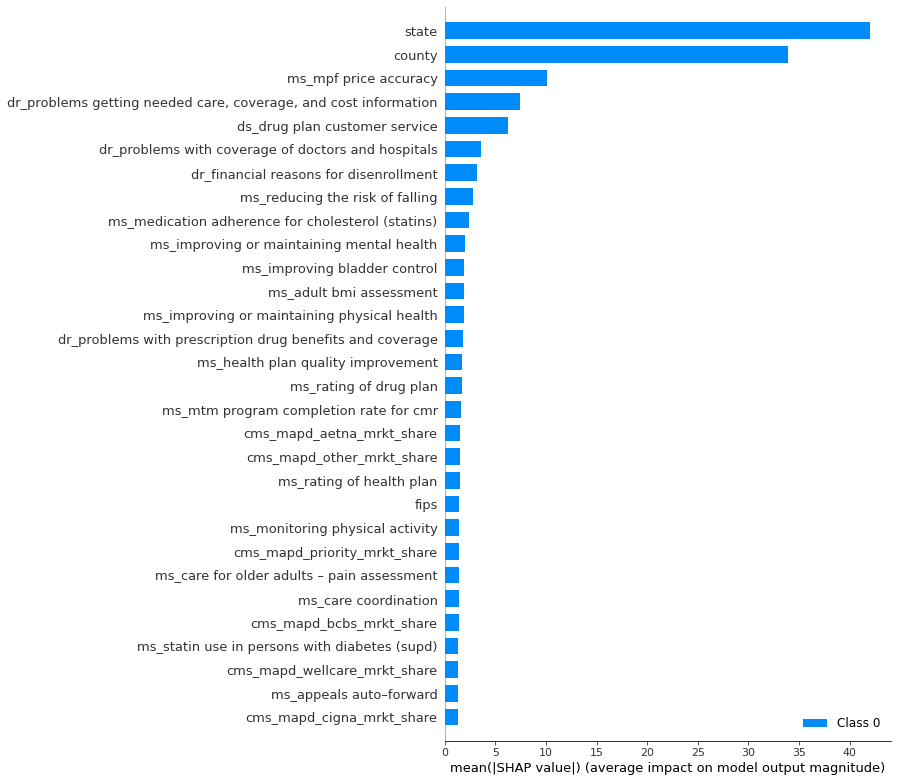

In [12]:
# ts = X_test.drop(columns="LTV")
# ts_lab = X_test["LTV"]

## SHAP
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data without Carrier info. Test dataset: 200k x 143")
plt.savefig(f"data/cms_ma_synth/test_synth_catboost.png", dpi=200, bbox_inches="tight")

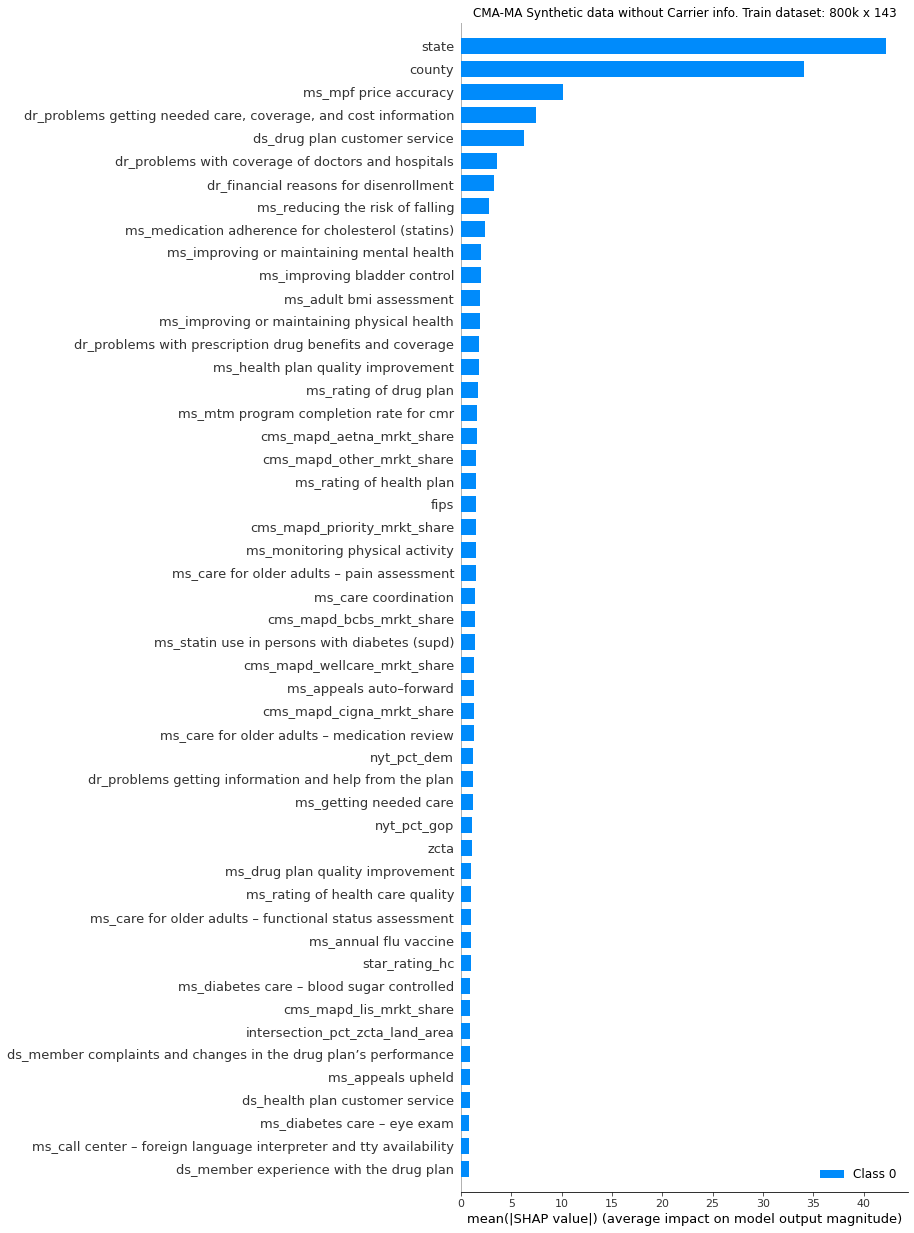

In [20]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data without Carrier info. Train dataset: 800k x 143")
plt.savefig(f"data/cms_ma_synth/train_synth_catboost.png", dpi=200, bbox_inches="tight")

In [68]:
X_train.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'carrier_hc',
       'star_rating_hc', 'zcta_land_area_m2', 'county_land_area_m2',
       ...
       'ms_improving or maintaining mental health', 'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms'],
      dtype='object', length=144)

### Carrier

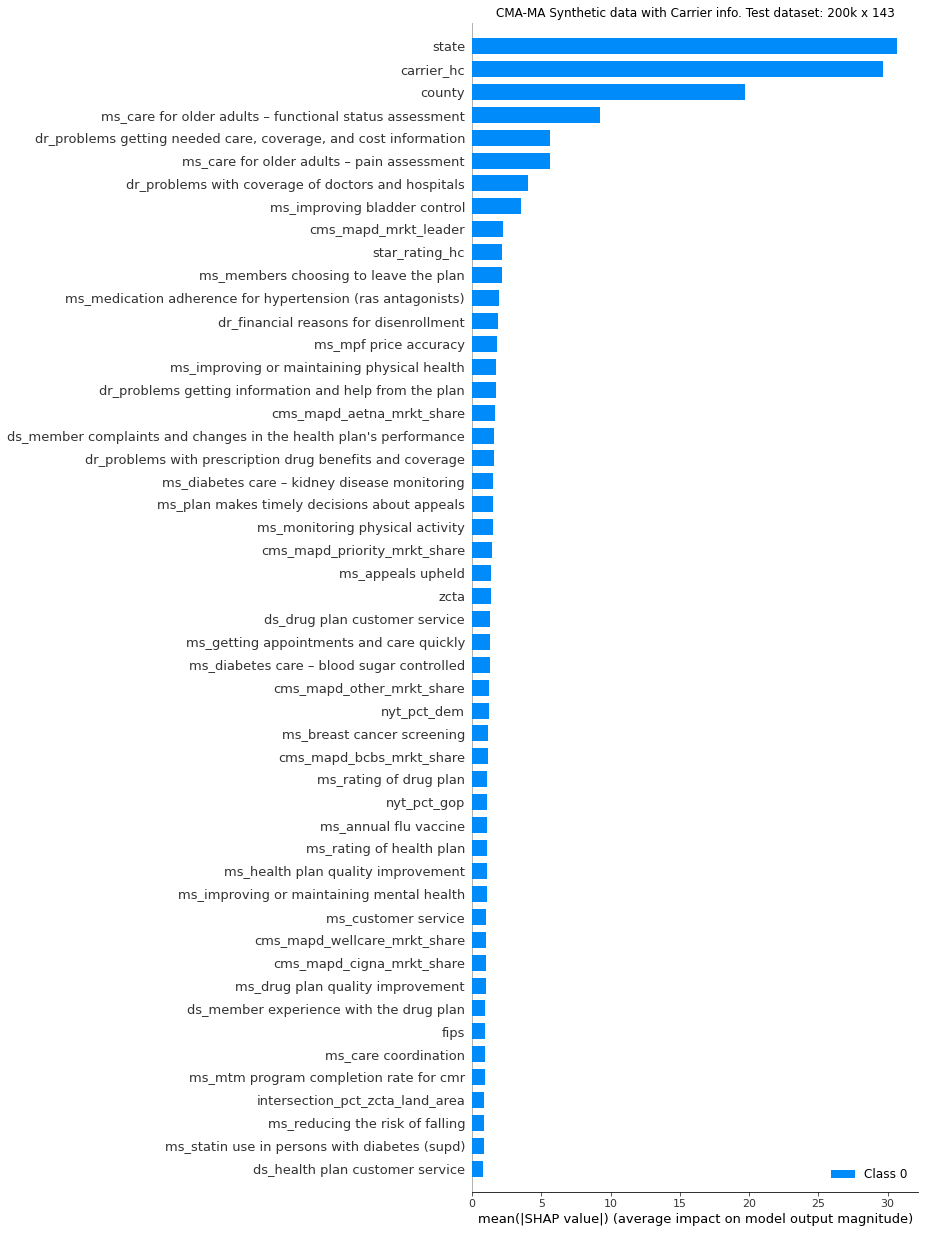

In [28]:
explainer = shap.TreeExplainer(model_carr)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data with Carrier info. Test dataset: 200k x 143")
plt.savefig(f"data/cms_ma_synth/test_synth_carr_catboost.png", dpi=200, bbox_inches="tight")

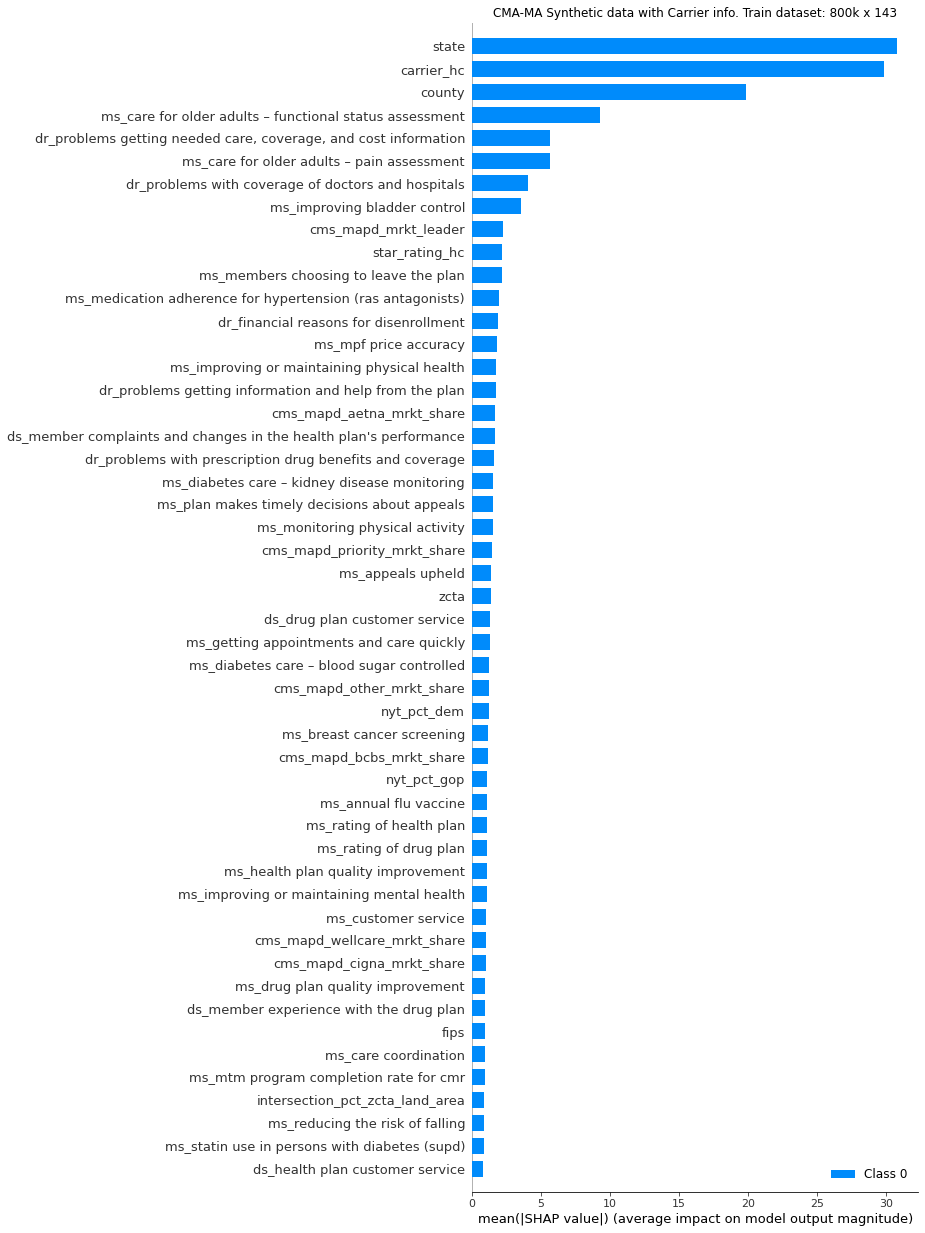

In [29]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data with Carrier info. Train dataset: 800k x 143")
plt.savefig(f"data/cms_ma_synth/train_synth_carr_catboost.png", dpi=200, bbox_inches="tight")

### Experimental Merging CMS-MA Synthetic data with ISC data

In [3]:
synth_data.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'contract_hc',
       'carrier_hc', 'type_hc', 'plan_hc',
       ...
       'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms', 'LTV'],
      dtype='object', length=153)

In [4]:
## Load Pre-Conversion MA data with Post-Conversion LTV Values
ma_data = pd.read_csv("data/with_zcta/ma_ltv_data.csv", low_memory=False)
ma_data.head()

,application_id,owner_email,application_name,policy_id,owner_id,owner_phone,parent_application_id,sk_referral_flag,bk_product_type,carrier,...,post_raw_application_id,post_raw_application_name,post_raw_policy_id,post_raw_carrier,post_raw_zcta,LTV,zip,state,city,gender
0,01218aa1-14ee-4844-85ed-a1a24941ccf1,NaN,Wellcare No Premium Open (PPO),34055980-504-001-000,7xw4v80fm74,5.203314e+09,01218aa1-14ee-4844-85ed-a1a24941ccf1,0.0,O65,O65 - Wellcare,...,01218aa1-14ee-4844-85ed-a1a24941ccf1,Wellcare No Premium Open (PPO),34055980-504-001-000,O65 - Wellcare,85704,509.250000,85704,AZ,TUCSON,M
1,0123cdb6-24f2-451f-b4c6-a34b9832eac1,olesauceda@gmail.com,Wellcare No Premium (HMO),C4053348601-H5294-011-000,1v20gr1ta31,9.562455e+09,0123cdb6-24f2-451f-b4c6-a34b9832eac1,0.0,O65,O65 - Wellcare,...,0123cdb6-24f2-451f-b4c6-a34b9832eac1,Wellcare No Premium (HMO),C4053348601-H5294-011-000,O65 - Wellcare,78583,442.500000,78583,TX,NaN,M
2,01c1b965-9369-42e2-8d86-cecad10badee,NaN,AARP Medicare Advantage Plan 1 (HMO-POS),OEC_SFTYX3HC6A1LT,4g10u97qr03,5.735628e+09,01c1b965-9369-42e2-8d86-cecad10badee,0.0,O65,O65 - United Health Care,...,01c1b965-9369-42e2-8d86-cecad10badee,AARP Medicare Advantage Plan 1 (HMO-POS),OEC_SFTYX3HC6A1LT,O65 - United Health Care,63653,984.245833,63653,MO,NaN,F
3,04615383-867d-469d-876b-8ac397481f3d,noemail@yahoo.com,Wellcare Giveback (HMO),34755918-444-193-000,6fh5j36rw62,3.862660e+09,04615383-867d-469d-876b-8ac397481f3d,0.0,O65,O65 - Wellcare,...,04615383-867d-469d-876b-8ac397481f3d,Wellcare Giveback (HMO),34755918-444-193-000,O65 - Wellcare,32117,0.000000,32117,FL,NaN,M
4,0484f9eb-864e-45ac-81b3-f56af9ec7608,NaN,HumanaChoice SNP-DE H5216-292 (PPO D-SNP),NaN,6p77p48ar59,6.625880e+09,0484f9eb-864e-45ac-81b3-f56af9ec7608,0.0,O65,O65 - Humana,...,0484f9eb-864e-45ac-81b3-f56af9ec7608,HumanaChoice SNP-DE H5216-292 (PPO D-SNP),NaN,O65 - Humana,38771,0.000000,38771,MS,NaN,F


In [5]:
## Match similarly-named columns in MA data with the ones in synthetic dataset
col_match = {}
for col in ma_data.columns:
    for c in synth_data.columns:
        if c.lower() in col.lower() or col.lower() in c.lower():
            if col not in col_match:
                col_match.update({
                    c : col
                })
col_match                

{'carrier_hc': 'carrier',
 'age': 'tu_demo_age_years',
 'zcta': 'post_raw_zcta',
 'latitude': 'zcta_latitude',
 'longitude': 'zcta_longitude',
 'cdc_all_teeth_lost': 'zcta_cdc_all_teeth_lost',
 'cdc_annual_checkup': 'zcta_cdc_annual_checkup',
 'cdc_arthritis': 'zcta_cdc_arthritis',
 'cdc_binge_drinking': 'zcta_cdc_binge_drinking',
 'cdc_cancer_except_skin': 'zcta_cdc_cancer_except_skin',
 'cdc_cervical_cancer_screening': 'zcta_cdc_cervical_cancer_screening',
 'cdc_cholesterol_screening': 'zcta_cdc_cholesterol_screening',
 'cdc_chronic_kidney_disease': 'zcta_cdc_chronic_kidney_disease',
 'cdc_colorectal_cancer_screening': 'zcta_cdc_colorectal_cancer_screening',
 'cdc_copd': 'zcta_cdc_copd',
 'cdc_core_preventive_services_for_older_men': 'zcta_cdc_core_preventive_services_for_older_men',
 'cdc_core_preventive_services_for_older_women': 'zcta_cdc_core_preventive_services_for_older_women',
 'cdc_coronary_heart_disease': 'zcta_cdc_coronary_heart_disease',
 'cdc_current_asthma': 'zcta_cdc_cu

In [6]:
## Calc age range for synth data
from utils.utils import get_age_range
synth_data["age_range"] = synth_data["age"].apply(lambda x: get_age_range(x))

## Fix some Column names
col_match["age"] = "age"
col_match["zcta"] = "zip"
col_match["age_range"] = "age_range"

col_match

{'carrier_hc': 'carrier',
 'age': 'age',
 'zcta': 'zip',
 'latitude': 'zcta_latitude',
 'longitude': 'zcta_longitude',
 'cdc_all_teeth_lost': 'zcta_cdc_all_teeth_lost',
 'cdc_annual_checkup': 'zcta_cdc_annual_checkup',
 'cdc_arthritis': 'zcta_cdc_arthritis',
 'cdc_binge_drinking': 'zcta_cdc_binge_drinking',
 'cdc_cancer_except_skin': 'zcta_cdc_cancer_except_skin',
 'cdc_cervical_cancer_screening': 'zcta_cdc_cervical_cancer_screening',
 'cdc_cholesterol_screening': 'zcta_cdc_cholesterol_screening',
 'cdc_chronic_kidney_disease': 'zcta_cdc_chronic_kidney_disease',
 'cdc_colorectal_cancer_screening': 'zcta_cdc_colorectal_cancer_screening',
 'cdc_copd': 'zcta_cdc_copd',
 'cdc_core_preventive_services_for_older_men': 'zcta_cdc_core_preventive_services_for_older_men',
 'cdc_core_preventive_services_for_older_women': 'zcta_cdc_core_preventive_services_for_older_women',
 'cdc_coronary_heart_disease': 'zcta_cdc_coronary_heart_disease',
 'cdc_current_asthma': 'zcta_cdc_current_asthma',
 'cdc_cur

In [7]:
synth_data_pp = synth_data.copy()

In [8]:
synth_data_pp.rename(columns=col_match, inplace= True)
synth_data_pp_trc = synth_data_pp[list(col_match.values())].copy()
synth_data_pp_trc

,carrier,age,zip,zcta_latitude,zcta_longitude,zcta_cdc_all_teeth_lost,zcta_cdc_annual_checkup,zcta_cdc_arthritis,zcta_cdc_binge_drinking,zcta_cdc_cancer_except_skin,...,zcta_usc_pct_hispanic_latino,zcta_usc_pct_native_hawaiian_pacific_islander,zcta_usc_pct_white,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,LTV,state,gender,age_range
0,O65 - United Health Care,65.0,31405,32.039402,-81.179112,18.6,77.1,24.3,16.6,6.0,...,5.6,0.1,42.0,469.01,95.2,37929.0,773.000000,GA,M,65 to 75
1,O65 - Centene Corporation,84.0,85716,32.242195,-110.923528,12.9,71.3,21.0,17.9,5.7,...,26.6,1.1,76.1,1654.56,98.0,30850.0,325.000000,AZ,F,75 to 85
2,O65 - United Health Care,66.0,60062,42.126279,-87.845088,5.8,79.6,26.4,19.8,9.5,...,3.6,0.0,78.2,815.28,90.9,39917.0,1052.000000,IL,F,65 to 75
3,O65 - Humana,73.0,24563,37.059343,-79.272620,17.8,80.7,33.5,13.7,8.1,...,3.4,0.0,78.4,29.01,99.8,5164.0,249.333333,VA,M,65 to 75
4,O65 - United Health Care,82.0,75477,33.529909,-95.738073,20.1,75.4,29.8,16.1,8.1,...,5.5,0.0,88.0,7.69,108.5,1172.0,450.916667,TX,F,75 to 85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,O65 - Centene Corporation,69.0,43207,39.895414,-82.963853,24.7,76.5,30.3,17.4,7.0,...,3.2,0.0,65.7,786.80,97.3,47118.0,780.000000,OH,M,65 to 75
999996,O65 - Humana,69.0,85367,32.660831,-114.393618,13.2,81.5,35.8,11.9,12.6,...,23.8,0.1,84.1,226.66,97.2,22067.0,436.333333,AZ,F,65 to 75
999997,O65 - United Health Care,68.0,74501,34.984203,-95.786716,21.3,77.1,29.7,13.0,7.8,...,6.1,0.2,72.5,19.65,108.1,28019.0,897.000000,OK,M,65 to 75
999998,O65 - Humana,71.0,33165,25.734345,-80.358271,12.1,77.0,20.5,15.9,6.4,...,90.6,0.0,80.5,2803.45,93.1,54497.0,498.666667,FL,M,65 to 75


In [9]:
ma_data_trc = ma_data[list(col_match.values())].copy()
ma_data_trc

,carrier,age,zip,zcta_latitude,zcta_longitude,zcta_cdc_all_teeth_lost,zcta_cdc_annual_checkup,zcta_cdc_arthritis,zcta_cdc_binge_drinking,zcta_cdc_cancer_except_skin,...,zcta_usc_pct_hispanic_latino,zcta_usc_pct_native_hawaiian_pacific_islander,zcta_usc_pct_white,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,LTV,state,gender,age_range
0,O65 - Wellcare,76.0,85704,32.339420,-110.984997,9.8,77.0,26.6,15.5,9.2,...,18.9,0.0,82.0,729.91,92.2,34413.0,509.250000,AZ,M,75 to 85
1,O65 - Wellcare,78.0,78583,26.285511,-97.471595,20.0,75.0,22.8,17.7,6.4,...,80.5,0.0,76.1,28.67,92.0,6915.0,442.500000,TX,M,75 to 85
2,O65 - United Health Care,90.0,63653,37.861318,-90.587878,23.2,71.7,27.1,17.9,6.5,...,0.3,0.0,99.0,522.24,69.6,1472.0,984.245833,MO,F,More than 85
3,O65 - Wellcare,66.0,32117,29.232739,-81.068471,24.2,76.4,29.5,18.2,7.5,...,9.8,0.0,60.8,909.78,94.3,28266.0,0.000000,FL,M,65 to 75
4,O65 - Humana,79.0,38771,33.739586,-90.523058,23.3,83.6,30.7,10.9,6.5,...,1.0,0.0,20.1,21.25,80.9,2980.0,0.000000,MS,F,75 to 85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21382,O65 - Humana,73.0,34488,29.219283,-81.941004,21.3,NaN,NaN,NaN,NaN,...,7.9,0.0,86.8,51.72,109.2,11472.0,0.000000,FL,F,65 to 75
21383,O65 - Humana,64.0,39507,30.400484,-89.034466,15.5,77.2,28.8,14.6,7.3,...,6.2,0.0,66.7,798.68,83.9,17004.0,0.000000,MS,M,Less than 65
21384,O65 - Wellcare,70.0,79411,33.570115,-101.857732,20.6,69.4,17.7,18.9,4.2,...,48.0,0.0,79.0,1733.01,111.3,6661.0,0.000000,TX,F,65 to 75
21385,O65 - United Health Care,72.0,72202,34.738130,-92.247251,20.1,80.9,25.9,13.7,6.1,...,3.2,0.9,46.4,533.44,89.4,9778.0,0.000000,AR,M,65 to 75


In [10]:
## Merge MA and CMS_MA Synthetic data
synth_ma_ = pd.concat([synth_data_pp_trc, ma_data_trc])
synth_ma_

,carrier,age,zip,zcta_latitude,zcta_longitude,zcta_cdc_all_teeth_lost,zcta_cdc_annual_checkup,zcta_cdc_arthritis,zcta_cdc_binge_drinking,zcta_cdc_cancer_except_skin,...,zcta_usc_pct_hispanic_latino,zcta_usc_pct_native_hawaiian_pacific_islander,zcta_usc_pct_white,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,LTV,state,gender,age_range
0,O65 - United Health Care,65.0,31405,32.039402,-81.179112,18.6,77.1,24.3,16.6,6.0,...,5.6,0.1,42.0,469.01,95.2,37929.0,773.000000,GA,M,65 to 75
1,O65 - Centene Corporation,84.0,85716,32.242195,-110.923528,12.9,71.3,21.0,17.9,5.7,...,26.6,1.1,76.1,1654.56,98.0,30850.0,325.000000,AZ,F,75 to 85
2,O65 - United Health Care,66.0,60062,42.126279,-87.845088,5.8,79.6,26.4,19.8,9.5,...,3.6,0.0,78.2,815.28,90.9,39917.0,1052.000000,IL,F,65 to 75
3,O65 - Humana,73.0,24563,37.059343,-79.272620,17.8,80.7,33.5,13.7,8.1,...,3.4,0.0,78.4,29.01,99.8,5164.0,249.333333,VA,M,65 to 75
4,O65 - United Health Care,82.0,75477,33.529909,-95.738073,20.1,75.4,29.8,16.1,8.1,...,5.5,0.0,88.0,7.69,108.5,1172.0,450.916667,TX,F,75 to 85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21382,O65 - Humana,73.0,34488,29.219283,-81.941004,21.3,NaN,NaN,NaN,NaN,...,7.9,0.0,86.8,51.72,109.2,11472.0,0.000000,FL,F,65 to 75
21383,O65 - Humana,64.0,39507,30.400484,-89.034466,15.5,77.2,28.8,14.6,7.3,...,6.2,0.0,66.7,798.68,83.9,17004.0,0.000000,MS,M,Less than 65
21384,O65 - Wellcare,70.0,79411,33.570115,-101.857732,20.6,69.4,17.7,18.9,4.2,...,48.0,0.0,79.0,1733.01,111.3,6661.0,0.000000,TX,F,65 to 75
21385,O65 - United Health Care,72.0,72202,34.738130,-92.247251,20.1,80.9,25.9,13.7,6.1,...,3.2,0.9,46.4,533.44,89.4,9778.0,0.000000,AR,M,65 to 75


## No carrier

In [67]:
def get_numeric_categorical(df: pd.DataFrame, target: str):
    # config = load_config_file(config_path=CONFIG_PATH)

    # determine categorical and numerical features
    numerical_cols = list(df.select_dtypes(include=["int", "float"]).columns)

    categorical_cols = list(
        df.select_dtypes(include=["object", "string", "bool"]).columns
    )

    force_categorical = ["zip"]
    for cat in force_categorical:
        feats = [col for col in df.columns if cat.lower() in col.lower()]

    for f in feats:
        if f not in categorical_cols:
            categorical_cols.append(f)
        if f in numerical_cols:
            numerical_cols.remove(f)

    # print("cate:", categorical_cols)
    # print("num:", len(numerical_cols))

    predictors = list(df.columns)
    predictors.remove(target)

    return numerical_cols, categorical_cols

In [68]:
## Post-process the Dataset
from utils.post_processing_utils import process_catboost
X_train, X_test = process_catboost(data=synth_ma_, config_path="config/config.ini", for_training=False, save_csv= False)

## Some preprocessing and get num and cat columns
target = "LTV"
num_cols, cat_cols = get_numeric_categorical(df=X_train, target=target)

In [58]:
type(X_train['zcta_usc_median_home_value'][232])

float

In [69]:
cat_cols

['carrier',
 'zip',
 'zcta_cms_mapd_mrkt_leader',
 'zcta_usc_median_home_value',
 'zcta_usc_pct_20_24',
 'zcta_usc_pct_25_34',
 'zcta_usc_pct_35_44',
 'zcta_usc_pct_45_54',
 'zcta_usc_pct_55_59',
 'zcta_usc_pct_60_64',
 'zcta_usc_pct_65_74',
 'zcta_usc_pct_65_over',
 'zcta_usc_pct_american_indian_alaska_native',
 'zcta_usc_pct_asian',
 'zcta_usc_pct_black',
 'zcta_usc_pct_hispanic_latino',
 'zcta_usc_pct_native_hawaiian_pacific_islander',
 'zcta_usc_pct_white',
 'zcta_usc_sex_ratio',
 'state',
 'gender',
 'age_range']

In [70]:


for col in num_cols:
    X_train[col] = X_train[col].fillna(-99)
    X_test[col] = X_test[col].fillna(-99)
for col in cat_cols:
    X_train[col] = X_train[col].astype("str")
    X_train[col] = X_train[col].fillna("N/A")
    X_test[col] = X_test[col].fillna("N/A")
    X_test[col] = X_test[col].astype("str")
# X_train = X_train.convert_dtypes()
# X_test = X_test.convert_dtypes()

num_cols.remove(target)

## Split Predictors and response variables
y_train = X_train[target]
y_test = X_test[target]
X_train = X_train.drop(columns=[target])
X_test = X_test.drop(columns=[target])

## No carrier

In [60]:
new_model = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

new_model.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4425769	total: 3.09s	remaining: 27m 45s
1:	learn: 7.4421257	total: 5.66s	remaining: 25m 23s
2:	learn: 7.4417429	total: 8.48s	remaining: 25m 18s
3:	learn: 7.4413757	total: 10.9s	remaining: 24m 25s
4:	learn: 7.4410055	total: 13.3s	remaining: 23m 39s
5:	learn: 7.4406622	total: 15.8s	remaining: 23m 25s
6:	learn: 7.4403128	total: 18.1s	remaining: 22m 56s
7:	learn: 7.4399633	total: 20.8s	remaining: 23m
8:	learn: 7.4396323	total: 23.2s	remaining: 22m 50s
9:	learn: 7.4393155	total: 25.7s	remaining: 22m 39s
10:	learn: 7.4390140	total: 28.2s	remaining: 22m 37s
11:	learn: 7.4386806	total: 30.8s	remaining: 22m 34s
12:	learn: 7.4383417	total: 33.3s	remaining: 22m 29s
13:	learn: 7.4380396	total: 35.8s	remaining: 22m 23s
14:	learn: 7.4377688	total: 38.2s	remaining: 22m 17s
15:	learn: 7.4374728	total: 40.7s	remaining: 22m 12s
16:	learn: 7.4371873	total: 43.1s	remaining: 22m 5s
17:	learn: 7.4369113	total: 45.5s	remaining: 22m
18:	learn: 7.4366285	total: 48.1s	remaining: 21m 58s
19:	learn: 7

In [62]:
from utils.utils import calc_regression_metrics
synth_metrics = calc_regression_metrics(new_model, X_train, y_train, X_test, y_test)
synth_metrics

{'MAE_train': 337.50682500608644,
 'MAE_test': 337.63497075036116,
 'RMSE_train': 407.3542741309563,
 'RMSE_test': 407.6294457359858,
 'R2_score_train': 0.028344469383739246,
 'R2_score_test': 0.02476678346898109,
 'train_preds_mean_stdev': 403.9083037961205,
 'test_preds_mean_stdev': 403.7048371076752,
 'test_preds_mean': 677.1128035641585}

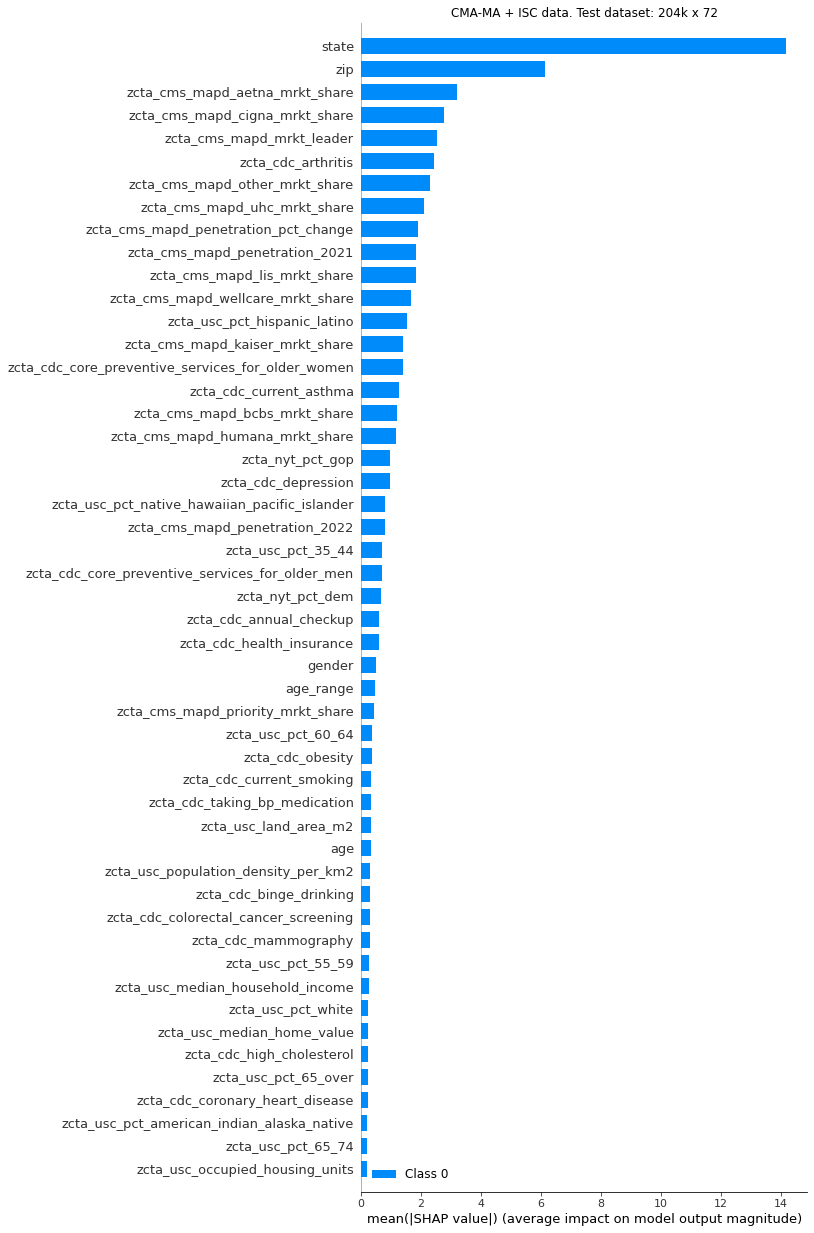

In [64]:
explainer = shap.TreeExplainer(new_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA + ISC data. Test dataset: 204k x 72")
plt.savefig(f"data/cms_ma_synth/test_synth_isc_catboost.png", dpi=200, bbox_inches="tight")

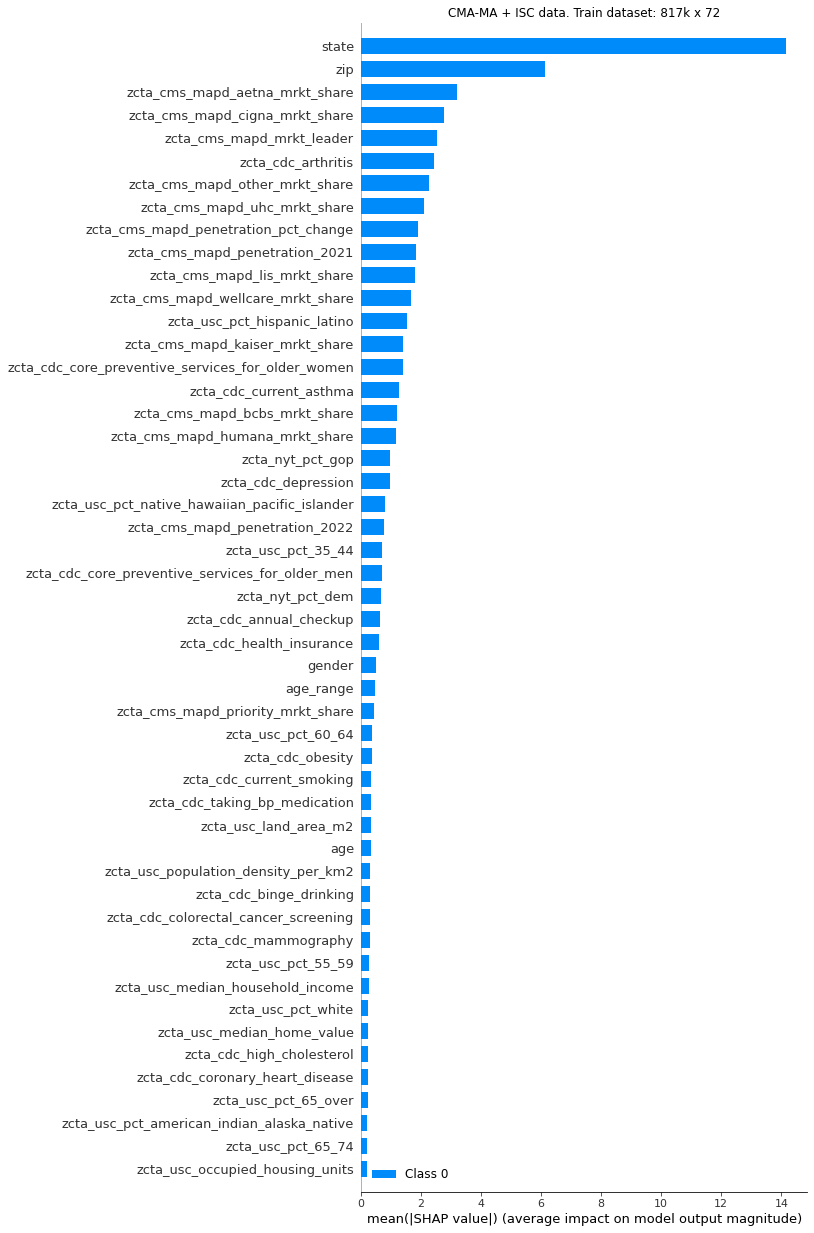

In [66]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA + ISC data. Train dataset: 817k x 72")
plt.savefig(f"data/cms_ma_synth/train_synth_isc_catboost.png", dpi=200, bbox_inches="tight")

In [65]:
X_train.shape

(817109, 72)

## With Carrier

In [71]:
new_model_carr = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

new_model_carr.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4402984	total: 4.28s	remaining: 38m 26s
1:	learn: 7.4379500	total: 6.96s	remaining: 31m 11s
2:	learn: 7.4357804	total: 10.1s	remaining: 30m
3:	learn: 7.4337687	total: 12.6s	remaining: 28m 7s
4:	learn: 7.4318675	total: 15.5s	remaining: 27m 34s
5:	learn: 7.4301501	total: 18.6s	remaining: 27m 37s
6:	learn: 7.4284769	total: 21.6s	remaining: 27m 27s
7:	learn: 7.4269627	total: 24.6s	remaining: 27m 18s
8:	learn: 7.4255223	total: 27.8s	remaining: 27m 18s
9:	learn: 7.4241684	total: 30.8s	remaining: 27m 13s
10:	learn: 7.4228392	total: 33.7s	remaining: 27m 2s
11:	learn: 7.4216335	total: 36.6s	remaining: 26m 51s
12:	learn: 7.4204745	total: 39.8s	remaining: 26m 54s
13:	learn: 7.4193941	total: 42.4s	remaining: 26m 33s
14:	learn: 7.4183175	total: 45s	remaining: 26m 13s
15:	learn: 7.4172256	total: 47.7s	remaining: 26m 2s
16:	learn: 7.4161910	total: 50.3s	remaining: 25m 47s
17:	learn: 7.4151987	total: 52.9s	remaining: 25m 33s
18:	learn: 7.4142659	total: 55.7s	remaining: 25m 28s
19:	learn: 7

In [73]:
synth_metrics_carr = calc_regression_metrics(new_model_carr, X_train, y_train, X_test, y_test)
synth_metrics_carr

{'MAE_train': 308.576249237268,
 'MAE_test': 310.3710498500524,
 'RMSE_train': 378.1749313864384,
 'RMSE_test': 379.96675806383007,
 'R2_score_train': 0.1625608780479324,
 'R2_score_test': 0.152638759272977,
 'train_preds_mean_stdev': 369.3434404405392,
 'test_preds_mean_stdev': 369.39559967787426,
 'test_preds_mean': 677.9058402234137}

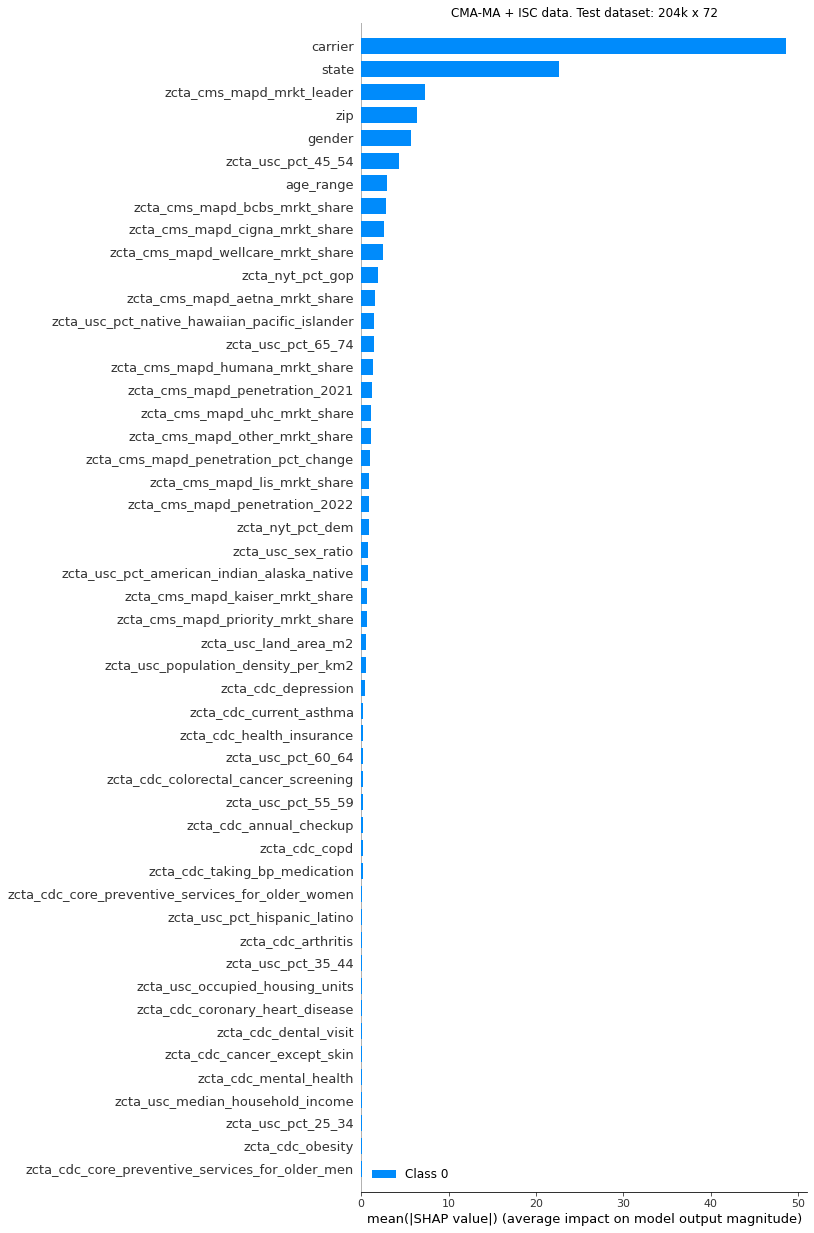

In [74]:
explainer = shap.TreeExplainer(new_model_carr)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA + ISC data. Test dataset: 204k x 72")
plt.savefig(f"data/cms_ma_synth/test_synth_isc_carr.png", dpi=200, bbox_inches="tight")

# STOP

In [55]:
select_feats = X_train.columns[np.argsort(np.abs(shap_values).mean(0))][-50:]
select_feats


Index(['zcta_cdc_current_asthma', 'zcta_cms_mapd_penetration_2021',
       'zcta_usc_median_household_income', 'zcta_usc_sex_ratio',
       'zcta_usc_pct_65_74', 'zcta_cdc_high_blood_pressure',
       'zcta_cdc_obesity', 'zcta_nyt_pct_dem', 'zcta_usc_land_area_m2',
       'tu_DEMO_HOMEVALUE_DOLLARS', 'tu_DEMO_EDUCATION_YEARS',
       'zcta_cdc_annual_checkup', 'area_code', 'zcta_cdc_physical_inactivity',
       'zcta_usc_pct_65_over', 'tu_STATE', 'zcta_usc_pct_white',
       'zcta_cms_mapd_other_mrkt_share', 'tu_DEMO_CHILDREN_NO',
       'tu_STATUS_COUNT', 'zcta_cdc_diabetes', 'tu_DEMO_RESIDENT_YEARS',
       'zcta_usc_occupied_housing_units', 'app_zip_code',
       'zcta_cdc_sleep_lt_7_hours', 'zcta_usc_housing_units',
       'zcta_cms_mapd_lis_mrkt_share', 'zcta_cdc_arthritis',
       'zcta_cms_mapd_penetration_pct_change', 'zcta_cdc_health_insurance',
       'zcta_cdc_colorectal_cancer_screening', 'zcta_nyt_pct_gop',
       'jrn_boberdoo_source', 'bk_gender', 'age',
       'zcta_cms

In [56]:
X_train[select_feats]

,zcta_cdc_current_asthma,zcta_cms_mapd_penetration_2021,zcta_usc_median_household_income,zcta_usc_sex_ratio,zcta_usc_pct_65_74,zcta_cdc_high_blood_pressure,zcta_cdc_obesity,zcta_nyt_pct_dem,zcta_usc_land_area_m2,tu_DEMO_HOMEVALUE_DOLLARS,...,zcta_cms_mapd_wellcare_mrkt_share,zcta_cms_mapd_uhc_mrkt_share,zcta_cms_mapd_aetna_mrkt_share,submitted_year,zcta_cms_mapd_humana_mrkt_share,bk_state,zcta_state,zcta_cms_mapd_mrkt_leader,submitted_month,pol_zip_code
0,-1.089763,1.480370,1.108518,1.151304,1.265321,-0.189711,-0.918669,1.045784,-0.562154,-0.531180,...,-0.562512,-0.609180,0.311334,-0.770723,0.797032,FL,FL,humana,0.788142,N/A
1,-0.104328,0.175655,-0.038891,0.609719,2.214198,0.009519,-0.056434,-0.330372,1.223426,-0.531180,...,-0.361205,0.835006,-0.358056,1.056994,-0.396044,AZ,AZ,uhc,-0.804586,None
2,-0.597046,0.666098,1.137421,-0.076645,-0.375980,-0.765264,-1.284823,0.794845,-0.477731,0.805417,...,-0.748452,1.403621,-0.521340,-0.770723,-1.301449,CA,CA,uhc,1.243207,None
3,1.821749,0.646446,-1.225465,-0.280410,-0.991467,1.238103,1.786151,1.061253,-0.557206,-0.149295,...,-0.730012,-0.807713,1.260861,1.056994,0.169204,OH,OH,humana,-1.259652,None
4,-0.641838,-0.337003,0.438849,0.261175,-0.658078,-0.233984,0.038058,-0.416310,0.333009,-0.531180,...,-0.451870,0.595513,-0.454788,1.056994,0.034958,TX,TX,uhc,-1.259652,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17008,0.746729,0.461889,-0.205143,-0.216063,-0.555497,-0.521761,0.286098,-0.456987,-0.336804,0.614475,...,-0.614760,0.097252,0.032744,1.056994,-0.357183,OH,OH,uhc,-1.032119,45324
17009,0.701936,-1.053870,-0.922671,-1.170539,0.752415,1.736178,1.148333,-0.368757,0.498569,-0.531180,...,3.297658,-1.150328,-0.981014,1.056994,1.026664,MS,MS,humana,-1.032119,None
17010,0.612351,-0.597605,-0.989038,0.395230,-0.581142,1.016737,0.959350,-0.400268,0.143890,0.614475,...,-0.161436,0.529014,-0.399844,-0.770723,0.022340,SC,SC,uhc,1.015675,None
17011,1.015484,0.062016,-1.006783,-0.183890,1.419193,1.570153,1.691660,0.400102,-0.549949,-0.531180,...,-0.794553,0.764170,0.726123,-0.770723,-0.796764,IL,IL,uhc,-0.349521,62203


In [138]:
from sklearn.feature_selection import mutual_info_regression

y = ma_data["mod_LTV"]
X = ma_data.drop(columns=["mod_LTV"])


In [166]:
x = pd.get_dummies(X)
x.shape

(21047, 7734)

In [139]:
numer_X = X[numeric_columns]
mir = mutual_info_regression(X= numer_X , y= y,
#  discrete_features=True
)
mir

array([0.01158549, 0.25345448, 0.2845237 , 0.10324138, 0.17735423,
       0.02898771, 0.03118692, 0.05015583, 0.01757793, 0.04115664,
       0.02241392, 0.00452497, 0.0015903 , 0.00717776, 0.00304683,
       0.        , 0.01037589, 0.01046569, 0.00779012, 0.00116442,
       0.00642738, 0.01134993, 0.        , 0.0082303 , 0.00914579,
       0.00411636, 0.00526285, 0.        , 0.        , 0.00087692,
       0.00274498, 0.00233561, 0.00162237, 0.006815  , 0.01588131,
       0.        , 0.01062128, 0.01992563, 0.        , 0.01615028,
       0.00461905, 0.00448124, 0.00461474, 0.00848722, 0.00332899,
       0.0032698 , 0.        , 0.00518087, 0.00491297, 0.00144835,
       0.        , 0.00601685, 0.00274981, 0.00732412, 0.01071005,
       0.11818431, 0.14606171, 0.08191963, 0.06869442, 0.07661655,
       0.07280195, 0.03421806, 0.04056755, 0.02434503, 0.06762243,
       0.04104344, 0.08834944, 0.03559017, 0.03224375, 0.08025633,
       0.05462521, 0.07885452, 0.06898416, 0.06525604, 0.08887

In [153]:
np.where(mir >0.2)[0]

array([1, 2])

In [156]:
numer_X.iloc[:, np.where(mir >0.2)[0]]

,app_zip_code,submitted_month
0,32507.0,11
1,24422.0,12
2,34221.0,4
3,70737.0,3
4,78102.0,3
...,...,...
21042,79414.0,12
21043,76115.0,12
21044,77053.0,2
21045,29687.0,12


In [140]:
numer_X

,sk_owner_gender,app_zip_code,submitted_month,submitted_year,area_code,age,jrn_boberdoo_amount,jrn_date,jrn_year,jrn_month,...,tu_DEMO_HOMEOWNER_YES,tu_DEMO_HOMEOWNER_NO,tu_DEMO_HOMEVALUE_DOLLARS,tu_DEMO_RESIDENT_YEARS,tu_STATUS_COUNT,tu_STATUS_LATENCY,tu_SUB_USER_ID,tu_ACCOUNT,tu_CONTACT_SCORE,tu_CREDIT_SCORE
0,10004,32507.0,11,2021,850.0,84,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,10004,24422.0,12,2021,540.0,56,0.00,0.000000e+00,0.0,0.0,...,100.0,0.0,100000.0,12.0,17.0,0.360621,5349.0,5349.0,42.0,556.0
2,10008,34221.0,4,2022,941.0,64,13.72,1.646928e+09,2022.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,10004,70737.0,3,2022,225.0,64,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.328247,5349.0,5349.0,313.0,486.0
4,10004,78102.0,3,2022,361.0,72,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21042,10004,79414.0,12,2021,806.0,71,0.00,1.632671e+09,2021.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21043,10008,76115.0,12,2021,682.0,70,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21044,10004,77053.0,2,2022,832.0,77,0.00,0.000000e+00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21045,10004,29687.0,12,2021,864.0,85,0.00,0.000000e+00,0.0,0.0,...,100.0,0.0,150000.0,30.0,18.0,0.355200,5349.0,5349.0,931.0,689.0


In [141]:
from sklearn.feature_selection import SelectPercentile
numer_X = X[numeric_columns]
selector = SelectPercentile(score_func= mutual_info_regression, percentile=70)
selector.fit(numer_X, y)

tr = selector.transform(numer_X)

In [142]:
(selector.get_feature_names_out())

array(['sk_owner_gender', 'app_zip_code', 'submitted_month',
       'submitted_year', 'area_code', 'age', 'jrn_boberdoo_amount',
       'jrn_date', 'jrn_year', 'jrn_month', 'jrn_day',
       'jrn_response_audit_authentic', 'jrn_response_audit_consumer_week',
       'jrn_response_audit_fields_email',
       'jrn_response_audit_fields_city',
       'jrn_response_audit_fields_state',
       'jrn_response_audit_device_week', 'jrn_response_audit_ip_hour',
       'jrn_response_audit_lead_age', 'jrn_response_audit_lead_duration',
       'jrn_response_audit_lead_five_minutes',
       'jrn_response_audit_result', 'zcta_latitude', 'zcta_longitude',
       'zcta_cdc_all_teeth_lost', 'zcta_cdc_annual_checkup',
       'zcta_cdc_arthritis', 'zcta_cdc_binge_drinking',
       'zcta_cdc_cancer_except_skin',
       'zcta_cdc_cervical_cancer_screening',
       'zcta_cdc_cholesterol_screening',
       'zcta_cdc_chronic_kidney_disease',
       'zcta_cdc_colorectal_cancer_screening', 'zcta_cdc_copd',
      

In [143]:
[f for f in numer_X.columns if f not in selector.get_feature_names_out()]

['jrn_hour',
 'jrn_response_audit_consumer_five_minutes',
 'jrn_response_audit_consumer_hour',
 'jrn_response_audit_consumer_twelve_hours',
 'jrn_response_audit_consumer_twelve_consumer_day',
 'jrn_response_audit_data_integrity',
 'jrn_response_audit_fields_f_name',
 'jrn_response_audit_fields_l_name',
 'jrn_response_audit_fields_phone1',
 'jrn_response_audit_fields_address1',
 'jrn_response_audit_device_five_minutes',
 'jrn_response_audit_device_hour',
 'jrn_response_audit_device_twelve_hours',
 'jrn_response_audit_device_day',
 'jrn_response_audit_consumer_dupe_check',
 'jrn_response_audit_ip_five_minutes',
 'jrn_response_audit_ip_twelve_hours',
 'jrn_response_audit_ip_day',
 'jrn_response_audit_ip_week',
 'jrn_response_audit_age',
 'jrn_response_audit_duration',
 'jrn_response_audit_lead_dupe_check',
 'jrn_response_audit_lead_dupe',
 'jrn_response_audit_lead_hour',
 'jrn_response_audit_lead_twelve_hours',
 'jrn_response_audit_lead_day',
 'jrn_response_audit_lead_week',
 'jrn_respons

In [144]:
pd.DataFrame(tr, columns=selector.get_feature_names_out())

,sk_owner_gender,app_zip_code,submitted_month,submitted_year,area_code,age,jrn_boberdoo_amount,jrn_date,jrn_year,jrn_month,...,zcta_usc_population_density_per_km2,zcta_usc_sex_ratio,zcta_usc_total_population,tu_ZIP,tu_DEMO_INCOME_DOLLARS,tu_DEMO_CHILDREN_NO,tu_DEMO_EDUCATION_YEARS,tu_DEMO_RESIDENT_YEARS,tu_STATUS_LATENCY,tu_CONTACT_SCORE
0,10004.0,32507.0,11.0,2021.0,850.0,84.0,0.00,0.000000e+00,0.0,0.0,...,466.67,101.0,33689.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,10004.0,24422.0,12.0,2021.0,540.0,56.0,0.00,0.000000e+00,0.0,0.0,...,28.91,88.6,5953.0,244229614.0,85000.0,100.0,13.0,12.0,0.360621,42.0
2,10008.0,34221.0,4.0,2022.0,941.0,64.0,13.72,1.646928e+09,2022.0,3.0,...,364.29,96.5,50857.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,10004.0,70737.0,3.0,2022.0,225.0,64.0,0.00,0.000000e+00,0.0,0.0,...,319.96,100.7,44744.0,70737.0,0.0,0.0,0.0,0.0,0.328247,313.0
4,10004.0,78102.0,3.0,2022.0,361.0,72.0,0.00,0.000000e+00,0.0,0.0,...,20.73,169.3,28253.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21042,10004.0,79414.0,12.0,2021.0,806.0,71.0,0.00,1.632671e+09,2021.0,9.0,...,2167.88,92.9,17806.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
21043,10008.0,76115.0,12.0,2021.0,682.0,70.0,0.00,0.000000e+00,0.0,0.0,...,1821.00,103.0,21907.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
21044,10004.0,77053.0,2.0,2022.0,832.0,77.0,0.00,0.000000e+00,0.0,0.0,...,1069.56,102.1,31521.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
21045,10004.0,29687.0,12.0,2021.0,864.0,85.0,0.00,0.000000e+00,0.0,0.0,...,328.98,89.9,41098.0,296873739.0,100000.0,100.0,13.0,30.0,0.355200,931.0


In [157]:
X

,application_name,sk_owner_gender,app_zip_code,carrier,bk_gender,submitted_month,submitted_year,area_code,age,age_range,...,tu_DEMO_HOMEOWNER_NO,tu_DEMO_HOMEVALUE_DOLLARS,tu_DEMO_RESIDENT_YEARS,tu_DEMO_OCCUPATION_FIRST,tu_STATUS_COUNT,tu_STATUS_LATENCY,tu_SUB_USER_ID,tu_ACCOUNT,tu_CONTACT_SCORE,tu_CREDIT_SCORE
0,Wellcare Dual Access (HMO D-SNP),10004,32507.0,O65 - Wellcare,F,11,2021,850.0,84,75 to 85,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
1,HumanaChoice H5216-248 (PPO),10004,24422.0,O65 - Humana,F,12,2021,540.0,56,Less than 65,...,0.0,100000.0,12.0,N/A,17.0,0.360621,5349.0,5349.0,42.0,556.0
2,AARP Medicare Advantage Plan 2 (HMO),10008,34221.0,O65 - United Health Care,M,4,2022,941.0,64,Less than 65,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
3,Humana Gold Plus H1951-048 (HMO),10004,70737.0,O65 - Humana,F,3,2022,225.0,64,Less than 65,...,0.0,0.0,0.0,N/A,10.0,0.328247,5349.0,5349.0,313.0,486.0
4,Humana Gold Plus H0028-029 (HMO),10004,78102.0,O65 - Humana,F,3,2022,361.0,72,65 to 75,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21042,Humana Honor (PPO),10004,79414.0,O65 - Humana,F,12,2021,806.0,71,65 to 75,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
21043,AARP Medicare Advantage (HMO-POS),10008,76115.0,O65 - United Health Care,M,12,2021,682.0,70,65 to 75,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
21044,Cigna TotalCare (HMO D-SNP),10004,77053.0,O65 - Cigna,F,2,2022,832.0,77,75 to 85,...,0.0,0.0,0.0,N/A,0.0,0.000000,0.0,0.0,0.0,0.0
21045,HumanaChoice H5216-154 (PPO),10004,29687.0,O65 - Humana,F,12,2021,864.0,85,More than 85,...,0.0,150000.0,30.0,professional,18.0,0.355200,5349.0,5349.0,931.0,689.0


In [158]:
## Train-Test Split
y = ma_data["mod_LTV"]
X = ma_data.drop(columns=["mod_LTV"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [159]:
model = catboost.CatBoostRegressor(
    iterations=1000, 
    depth=10, 
    learning_rate=0.01, 
    loss_function='RMSE'
)

model.fit(
    X_train, 
    y_train,
    cat_features=categorical_columns,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 372.4905840	total: 154ms	remaining: 2m 33s
1:	learn: 370.5179777	total: 234ms	remaining: 1m 56s
2:	learn: 368.5346138	total: 324ms	remaining: 1m 47s
3:	learn: 366.6359995	total: 386ms	remaining: 1m 36s
4:	learn: 364.7660792	total: 473ms	remaining: 1m 34s
5:	learn: 362.8166764	total: 533ms	remaining: 1m 28s
6:	learn: 360.9565131	total: 584ms	remaining: 1m 22s
7:	learn: 359.2476078	total: 602ms	remaining: 1m 14s
8:	learn: 357.4113987	total: 663ms	remaining: 1m 13s
9:	learn: 355.6138705	total: 737ms	remaining: 1m 12s
10:	learn: 353.9063077	total: 794ms	remaining: 1m 11s
11:	learn: 352.1853881	total: 863ms	remaining: 1m 11s
12:	learn: 350.4269072	total: 928ms	remaining: 1m 10s
13:	learn: 348.7612824	total: 986ms	remaining: 1m 9s
14:	learn: 347.0635098	total: 1.04s	remaining: 1m 8s
15:	learn: 345.3883858	total: 1.1s	remaining: 1m 7s
16:	learn: 343.7792306	total: 1.14s	remaining: 1m 6s
17:	learn: 342.3796452	total: 1.15s	remaining: 1m 2s
18:	learn: 340.7920031	total: 1.2s	remaining

In [160]:
results = pd.DataFrame()
results['true_LTV'] = y_test
y_preds = model.predict(X_test)
results['pred_LTV'] = y_preds
results.reset_index(drop=True)

,true_LTV,pred_LTV
0,706.666667,605.015658
1,0.000000,82.452062
2,0.000000,674.993948
3,682.564103,660.775631
4,691.282051,565.426810
...,...,...
4205,757.948718,630.363934
4206,834.358974,670.869402
4207,800.512821,807.798601
4208,606.666667,565.427196


In [161]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_preds)))
print("MAE: ", mean_absolute_error(y_test, y_preds))
# print("MAPE: ", mean_absolute_percentage_error(y_test, y_preds))
print("R2 Score: ", r2_score(y_test, y_preds))
mean = np.mean(y_test)
print("Mean:", mean)
# print("NRMSE: ", np.sqrt(mean_squared_error(y_test, y_preds))/mean)
# print("NMAE: ", mean_absolute_error(y_test, y_preds)/mean)



RMSE:  233.21449679623157
MAE:  152.51034085590868
R2 Score:  0.6122509326869332
Mean: 494.92161520190064


In [1]:
# ma_data.application_name.unique()
# ma_data.carrier.unique()
import boto3
boto3.resource("iam").CurrentUser().arn

'arn:aws:iam::915124832670:user/rutvik.bhende'

## SHAP analysis

In [163]:
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

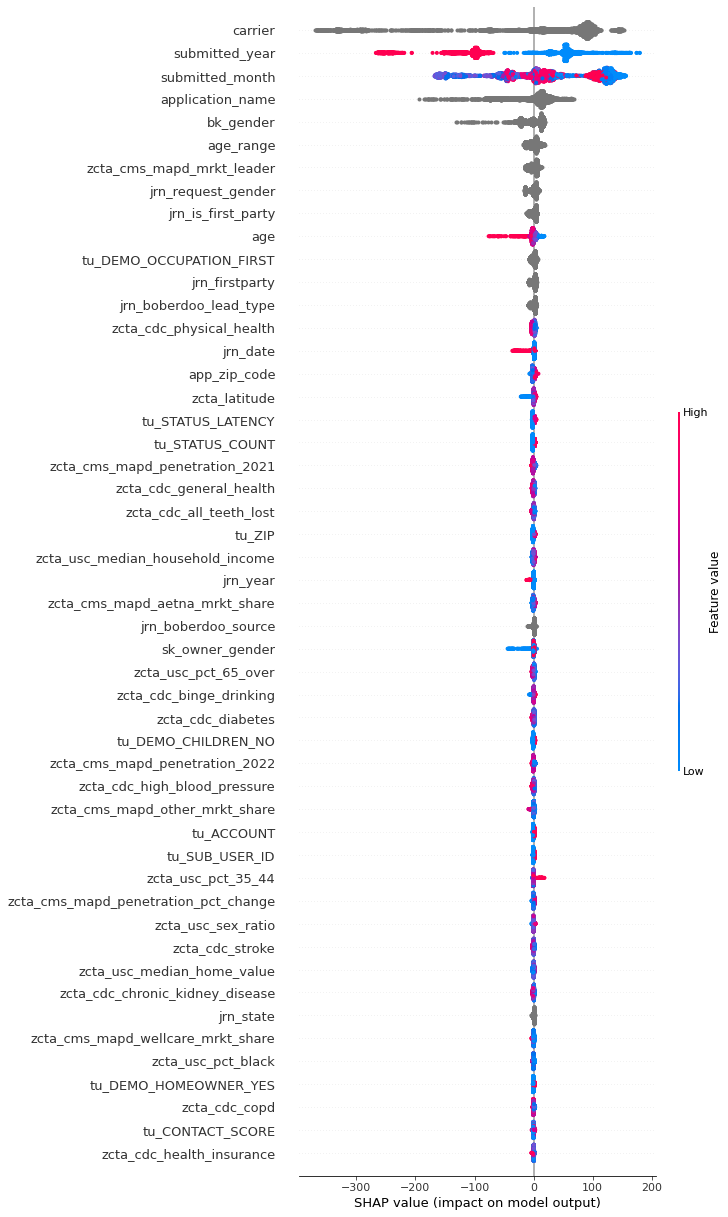

In [164]:
shap.summary_plot(
    shap_values, features=X_test, feature_names=X_test.columns, max_display=50
)

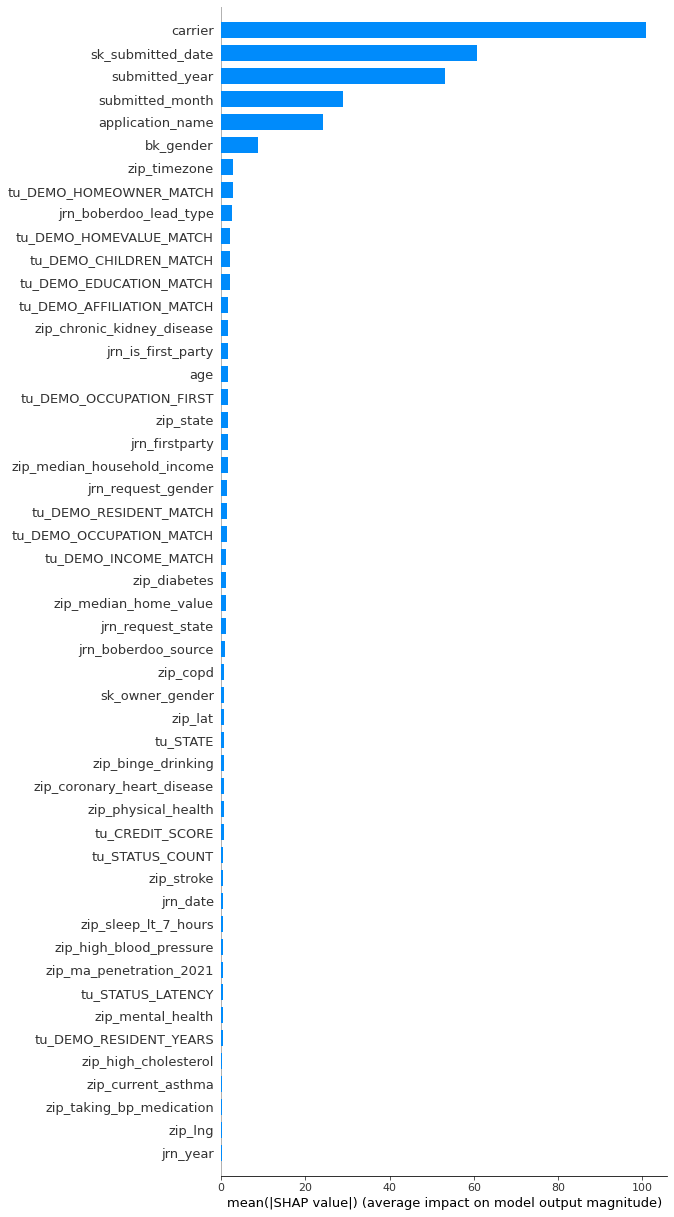

In [22]:
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns, max_display=50, plot_type="bar")

# LGBM

In [16]:
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from lightgbm import Dataset, train
from utils.load_config_file import load_config_file

data = pd.read_csv("data/with_zcta/ma_ltv_merged.csv", low_memory=False)
config = load_config_file(config_path="config/config.ini")
## Remove unwanted features
unwanted_features = config["unwanted_features"]

## Remove any post-conversion data features; replace nulls with 0 or N/A
unwanted_features = (
    unwanted_features
    + [p for p in data.columns if "post_raw" in p.lower()]
    + [c for c in data.columns if len(data[c].fillna(0).unique()) == 1]
)
data = data.drop(columns=unwanted_features)

# replace Null values with 0 for numeric columns and N/A for categorical
categorical_columns = []
numeric_columns = []
for col in data.columns:
    if data[col].dtype in ["i", "f", int, float]:
        numeric_columns.append(col)
        data[col].fillna(0, inplace=True)
    elif data[col].dtype in ["O", "S", "a"]:
        categorical_columns.append(col)
        data[col].fillna("N/A", inplace=True)
        data[col] = pd.Series(data[col], dtype="category")
    else:
        data[col].fillna("N/A", inplace=True)
numeric_columns.remove("LTV")  # Target Variable

## Train-Test Split
y = data["LTV"]
X = data.drop(columns=["LTV"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    "n_estimators": 200,
    'learning_rate': 0.01,
    "num_leaves": 128,  
    "max_depth": 10
}
lgb_train = Dataset(X_train, y_train)
gbm = train(hyper_params, lgb_train, num_boost_round=10)

# data.head()

/Users/rutvikb/opt/anaconda3/envs/mlflow/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18363
[LightGBM] [Info] Number of data points in the train set: 16933, number of used features: 150
[LightGBM] [Info] Start training from score 436.847033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [17]:
pr = gbm.predict(X_test)
pr

array([790.78157799,  58.65406977,  60.55796873, ..., 749.08008063,
        58.51974321,  58.65406977])

In [18]:
from utils.utils import calc_regression_metrics
met = calc_regression_metrics(
    model= gbm,
    X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
met

{'test_preds_mean': 431.47407290962053,
 'MAE_train': 122.42334130898399,
 'MAE_test': 133.7739484713906,
 'RMSE_train': 183.15146634351746,
 'RMSE_test': 211.61722442690822,
 'R2_score_train': 0.8580083496492462,
 'R2_score_test': 0.8108830038328542}

In [8]:
met

app_zip_code          float64
pol_zip_code         category
carrier              category
bk_gender            category
submitted_weekday       int64
                       ...   
tu_STATUS_COUNT       float64
tu_STATUS_LATENCY     float64
tu_CONTACT_SCORE      float64
tu_CREDIT_SCORE       float64
LTV                   float64
Length: 160, dtype: object

In [ ]:
python train_lgbm.py --experiment_name rb_test1 --data_path data/with_zcta/ma_ltv_merged.csv 

# XGBOOST

In [2]:
import pickle
with open("data/features.pkl", "rb+") as f:
    m = pickle.load(f)


In [4]:
m['predictor']

['submitted_weekday',
 'submitted_day',
 'submitted_month',
 'submitted_year',
 'area_code',
 'age',
 'age_range',
 'jrn_boberdoo_amount',
 'jrn_boberdoo_source',
 'jrn_boberdoo_lead_type',
 'jrn_firstparty',
 'jrn_year',
 'jrn_month',
 'jrn_day',
 'jrn_hour',
 'jrn_response_audit_authentic',
 'jrn_response_audit_consumer_five_minutes',
 'jrn_response_audit_consumer_hour',
 'jrn_response_audit_consumer_twelve_hours',
 'jrn_response_audit_consumer_twelve_consumer_day',
 'jrn_response_audit_consumer_week',
 'jrn_response_audit_data_integrity',
 'jrn_response_audit_device_five_minutes',
 'jrn_response_audit_device_hour',
 'jrn_response_audit_device_twelve_hours',
 'jrn_response_audit_device_day',
 'jrn_response_audit_device_week',
 'jrn_response_audit_consumer_dupe_check',
 'jrn_response_audit_ip_five_minutes',
 'jrn_response_audit_ip_hour',
 'jrn_response_audit_ip_twelve_hours',
 'jrn_response_audit_ip_day',
 'jrn_response_audit_ip_week',
 'jrn_response_audit_lead_age',
 'jrn_response_au